In [4]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_fit'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
# from mog_fit import data
from collections import OrderedDict
from sklearn import preprocessing

import torch
from torch.autograd import Variable
# from mog_analyze import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from vision_fit import data
import viz_weights
from process_results import process_results

%matplotlib inline
%load_ext autoreload
%autoreload 2

import style
cb = '#008fd5'
cr = '#fc4f30'

In [5]:
style.set_style()

# load results from a directory

In [6]:
# depending on how much is saved, this may take a while
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/resweep_full_new'
out_dir2 = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/resweep_full_new2'
fnames = sorted([oj(out_dir, fname) for fname in os.listdir(out_dir) \
                 if not fname.startswith('weights') \
                 and not fname.startswith('idx')])
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in tqdm(fnames) 
                if not fname.startswith('weights') and not fname.startswith('idx')]
results = pd.concat(results_list, axis=1).T.infer_objects()
print(results.shape)

100%|██████████| 1306/1306 [01:56<00:00, 11.17it/s]


(1306, 54)


**add cols**

In [8]:
# adds these vec keys: fc0_fro, fc1_fro, fc0_stab_rank, fc1_stab_rank, act0_stab_rank, act1_stab_rank, corr0, corr1
# adds these scalar keys: max_train_acc, max_test_acc, _final of all the above
# print('before', results.shape)
its, ts, results = process_results(results)
print('after', results.shape)

after (1219, 86)


# plot max corrs
*note some things disappear in below plot as a result of nans*

In [ ]:
r = results
# r = r[r.dset == 'mnist']
# r = r[r.hidden_size == 128]
r = r[r.max_test_acc >= 0.4]
r = r[r.dset == 'cifar10']
r = r[r.optimizer == 'sgd']
plt.figure(figsize=(14, 14), facecolor='w', dpi=100)
x = np.array(r.max_test_acc)
y = np.array(r.corr0_final)
# plt.plot(x, y, 'o')
# plt.scatter(x, y, c=r.optimizer=='sgd')
'''
pids = np.array([pid[:6] for pid in r.pid])
ax = sns.scatterplot(x, y, hue=r.optimizer)
plt.xlabel('max test acc')
plt.ylabel('corr0_final')

for i, pid in enumerate(pids):
    ax.annotate(pid, (x[i], y[i]))
'''

plt.show()

In [10]:
r = results

# pick examples

{2, 4, 7}

In [153]:
r = results
r = r[r.optimizer == 'sgd']
r = r[r.dset == 'cifar10']
r = r[r.num_layers == 2]
r = r[r.max_test_acc > 0.5]
print(r.shape)
# r = r[r.hidden_size == 512]

(24, 86)


In [ ]:
r[['lr', 'optimizer', 'hidden_size', 'num_layers']]

In [155]:
pids = r.pid[:5]

In [ ]:
curves = []
for i, pid_a in enumerate(tqdm(pids)):

    # depending on how much is saved, this may take a while
    out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/resweep_full_new'
    fnames = sorted([oj(out_dir, fname) for fname in os.listdir(out_dir) \
                     if (pid_a in fname)])
    # weights
    fnames_w = [fname for fname in fnames if 'weights' in fname]
    results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in fnames_w]
    rw = pd.concat(results_list, axis=1).T.infer_objects()

    # normal results
    fnames_acc = [fname for fname in fnames if '/pid' in fname] # normal results
    results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in fnames_acc]
    r = pd.concat(results_list, axis=1).T.infer_objects()
    its, ts, r = process_results(r)

    # get individual weights
    run = rw[rw.optimizer == 'sgd'].reset_index().iloc[0]

    # get accs
    r_sgd = r[r.optimizer == 'sgd'].reset_index().iloc[0]
    
    epoch = int(max(ts))
    print('sgd', r_sgd.accs_train[its == epoch], r_sgd.accs_test[its == epoch])
    
    # get data

    run['num_layer'] = int(run['num_layers'])
    run['hidden_size'] = int(run['hidden_size'])
    run['batch_size'] = int(run.batch_size)
    '''
    if i == 0:    
        train_loader, test_loader = data.get_data_loaders(run)
        X_train, Y_train, X_test, Y_test = data.process_loaders(train_loader, test_loader)
        # x = X_train.cpu().numpy().reshape(60000, 784)
        x = X_train.cpu().numpy().reshape(50000, 32*32*3)
    '''


    # load in weights
    weights_dict_dict = run['weights'] # keys are epochs, vals are dicts of all weights
    epochs = sorted(run['weights'].keys())


    ys = []
    for epoch in epochs[::4]:
        weights_dict = weights_dict_dict[epoch] # keys are layers, vals are weight values    
        weights_dict_tensors = {k: torch.Tensor(v) for k, v in weights_dict.items()}
        W = weights_dict_tensors['fc.0.weight'].cpu().numpy()
        y = x @ W.T
        ys.append(y)
    ys = np.array(ys)
    
    overlap_frac = []
    for i in range(ys.shape[0]):
        y0 = ys[i] > 0
        yf = ys[0] > 0
        num_overlap = np.sum(np.multiply(y0, yf))
        overlap_frac.append(num_overlap / yf.size)
    
    curves.append((epochs, [np.sum(ys[i] > 0) / ys[i].size for i in range(ys.shape[0])], overlap_frac))

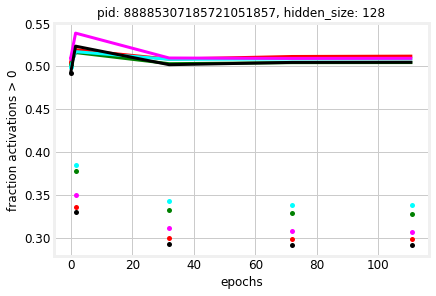

In [162]:
cs = ['red', 'green', 'cyan', 'magenta', 'black']
for i in range(len(curves)):
    epochs, ys_one, overlap_frac = curves[i]
    epochs = epochs[::4]
    ys_one = np.array(ys_one) 
    plt.plot(epochs, ys_one, '-', color=cs[i])
    plt.plot(epochs, overlap_frac, '.', color=cs[i])

plt.xlabel('epochs')
plt.ylabel('fraction activations > 0')
plt.title(f'pid: {pid}, hidden_size: {W.shape[0]}')
# plt.legend()
plt.show()

In [ ]:
from matplotlib.ticker import NullLocator

def get_w(run):
    run['num_layer'] = int(run['num_layers'])
    run['hidden_size'] = int(run['hidden_size'])
    lay = 'fc.0.weight'

    # keys are epochs, vals are dicts of all weights
    weights_dict_dict = run['weights']

    # keys are layers, vals are weight values
#     print(weights_dict_dict.keys())
    weights_dict = weights_dict_dict[epoch]
#     print(weights_dict.keys())
    w = weights_dict[lay]

    return w

for run in [rw_sgd]:
    w = get_w(run)
    # matrix of weights (output x input)
    viz_weights.plot_weights(w, dset='mnist', C=18, dpi=120)
                
    plt.gca().set_axis_off()
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    plt.margins(0, 0)

    plt.savefig(run.optimizer + '_' + str(run.hidden_size) + '_' + 'w0.pdf', 
                bbox_inches = 'tight', pad_inches = 0)